In [8]:
# This verison is difrectly modified from https://omlc.org/software/mc/mc321/mc321.c to python3
# The light source is a isotropic point source

import math
import random
import numpy as np

# Constants
PI = math.pi
LIGHTSPEED = 2.997925E10  # Speed of light in vacuum [cm/s]
ALIVE = 1                 # Photon is alive
DEAD = 0                  # Photon is dead
THRESHOLD = 0.01          # Threshold weight for Roulette
CHANCE = 0.1              # Chance of survival in Roulette
COS90D = 1.0E-6           # Cosine of angle close to 90 degrees
ONE_MINUS_COSZERO = 1.0E-12  # 1 minus cosine of angle close to 0 degrees

def SIGN(x):
    """Return the sign of x."""
    return 1 if x >= 0 else -1

def InitRandomGen(seed):
    """Initialize the random number generator with a specific seed."""
    random.seed(seed)

In [21]:
def HOP(x, y, z, ux, uy, uz, mua, mus):
    """
    Perform the HOP step: move the photon to a new position.

    Parameters:
        x, y, z (float): Current photon position coordinates.
        ux, uy, uz (float): Current photon trajectory cosines.
        mua (float): Absorption coefficient [cm^-1].
        mus (float): Scattering coefficient [cm^-1].

    Returns:
        x, y, z (float): Updated photon position coordinates.
        s (float): Step size taken [cm].
    """
    # Generate a random number (0,1) and calculate step size
    rnd = random.random()
    while rnd <= 0.0:
        rnd = random.random()
    s = -math.log(rnd) / (mua + mus)  # Step size [cm]

    # Update photon position
    x += s * ux
    y += s * uy
    z += s * uz

    return x, y, z, s

In [19]:
def DROP(x, y, z, W, albedo, dr, NR, Csph, Ccyl, Cpla):
    """
    Perform the DROP step: update photon weight and accumulate absorbed weight.

    Parameters:
        x, y, z (float): Current photon position coordinates.
        W (float): Current photon weight.
        albedo (float): Albedo (scattering probability).
        dr (float): Radial bin size [cm].
        NR (int): Number of radial bins.
        Csph, Ccyl, Cpla (list): Arrays to accumulate absorbed weights.

    Returns:
        W (float): Updated photon weight after absorption.
    """
    # Calculate absorbed weight and update photon weight
    absorb = W * (1.0 - albedo)  # Absorbed weight during this step
    W -= absorb                  # Decrease photon weight by absorbed amount

    # Accumulate absorbed weight in spatial bins

    # Spherical coordinates
    r = math.sqrt(x * x + y * y + z * z)  # Radial distance from origin [cm]
    ir = int(r / dr)                      # Determine radial bin index
    if ir >= NR:
        ir = NR                           # Assign to overflow bin if outside range
    Csph[ir] += absorb                    # Add absorbed weight to spherical bin

    # Cylindrical coordinates
    r_cyl = math.sqrt(x * x + y * y)      # Radial distance in xy-plane [cm]
    ir = int(r_cyl / dr)                  # Determine radial bin index
    if ir >= NR:
        ir = NR                           # Assign to overflow bin if outside range
    Ccyl[ir] += absorb                    # Add absorbed weight to cylindrical bin

    # Planar coordinates
    r_pla = abs(z)                        # Absolute z-position [cm]
    ir = int(r_pla / dr)                  # Determine radial bin index
    if ir >= NR:
        ir = NR                           # Assign to overflow bin if outside range
    Cpla[ir] += absorb                    # Add absorbed weight to planar bin

    return W,Csph, Ccyl, Cpla

## Scattering Anisotropy and Photon Direction Update (Spin function)
### Scattering Anisotropy Parameter ($g$)
The anisotropy of scattering is characterized by the parameter \( g \), which dictates the preferential direction of scattered photons:
- **Isotropic Scattering (\( g = 0 \))**:  
  Scattering is uniform in all directions. The probability of scattering into any direction is equal.
- **Forward Scattering (\( g > 0 \))**:  
  Scattering is predominantly in the forward direction. In biological tissues, the anisotropy factor \( g \) typically exceeds 0.9, indicating strong forward scattering.
- **Backward Scattering (\( g < 0 \))**:  
  Scattering is primarily in the backward direction.
---

### Probability Distribution Function (PDF) and Cumulative Distribution Function (CDF)
Understanding the relationship between the Probability Distribution Function (PDF) and the Cumulative Distribution Function (CDF) is crucial for accurately sampling scattering angles.
#### Probability Distribution Function (PDF)
The PDF describes the likelihood of scattering occurring at a specific angle  $\theta$ . For the Henyey-Greenstein (H-G) phase function, which models anisotropic scattering, the PDF is given by:
$$
p(\cos\theta) = \frac{1 - g^2}{(1 + g^2 - 2g\cos\theta)^{3/2}}
$$
where:
- $\theta$ is the scattering angle,
- $g$ is the anisotropy parameter.

### Cumulative Distribution Function (CDF)
The CDF is the integral of the PDF from the minimum possible value up to a specific value of $\cos\theta$. It represents the probability that $\cos\theta$ is less than or equal to a certain value.

$$
\text{CDF}(\cos\theta) = \int_{-1}^{\cos\theta} p(t) \, dt
$$

This relationship is fundamental in inverse transform sampling, where we use the CDF to generate random samples from the desired PDF.

---

### Sampling the Scattering Angle $\theta$ Using Inverse Transform Sampling

To simulate scattering events, we need to generate the scattering angle $\theta$ based on the PDF defined by the anisotropy parameter \( g \). This is achieved through inverse transform sampling, which involves the following steps:

1. **Generate a Uniform Random Number $\xi$**:  
   Generate a random number $\xi$ uniformly distributed in the interval \([0, 1]\).

2. **Set $\text{CDF}(\cos\theta) = \xi$**:  
   Equate the CDF to the random number and solve for \( \cos\theta \).

3. **Solve for $\cos\theta$**:  
   Derive an expression for $\cos\theta$ in terms of $\xi$ and $g$.

---

### Step 1: Define the Cumulative Distribution Function (CDF)

The CDF for $\cos\theta$ based on the H-G phase function is:

$$
\text{CDF}(\cos\theta) = \xi = \frac{(1 - g^2)}{2g} \left( \frac{1}{\sqrt{1 + g^2 - 2g\cos\theta}} - \frac{1}{1 + g} \right)
$$

where $\xi$ is a uniformly distributed random number in the interval \([0, 1]\).

---

### Step 2: Invert the CDF to Solve for $\cos\theta$

Depending on the value of $g$, the expression for $\cos\theta$ differs:

- **For $g \neq 0$**:

  Solving the CDF equation for $\cos\theta$, we obtain:

  $$
  \cos\theta = \frac{1}{2g} \left[ 1 + g^2 - \left( \frac{1 - g^2}{1 - g + 2g \xi} \right)^2 \right]
  $$

- **For \( g = 0 \) (Isotropic Scattering)**:

  The PDF \( p(\cos\theta) \) is uniform, with \( p(\cos\theta) = 0.5 \). Thus, the scattering angle is sampled as:

  $$
  \cos\theta = 2\xi - 1
  $$

---

### Updating the Photon's Direction After Scattering

Once $\theta $ is determined, we update the photon's direction vector using the scattering angles $\theta$ and $\phi$, where $\phi$ is uniformly sampled from $[0, 2\pi]$.

#### Initial Photon Direction

Let the initial unit direction vector of the photon be:

$$
\mathbf{k}_i = (k_{ix}, k_{iy}, k_{iz})
$$

#### Scattering Angles

- **Azimuthal Angle $\phi$**:  
  Sampled uniformly from ([0, 2 $\pi$]).

- **Polar Angle $\theta$**:  
  Sampled based on the Henyey-Greenstein (H-G) phase function as described above.

#### Scattered Photon Direction

Using Rodrigues' rotation formula, the new unit direction vector  $\mathbf{k}_s = (k_{sx}, k_{sy}, k_{sz})$ after scattering is calculated as follows:

$$
\begin{align*}
k_{sx} &= k_{ix} \cos\theta + \frac{\sin\theta \left( k_{ix} k_{iz} \cos\phi - k_{iy} \sin\phi \right)}{\sqrt{1 - k_{iz}^2}} \\
k_{sy} &= k_{iy} \cos\theta + \frac{\sin\theta \left( k_{iy} k_{iz} \cos\phi + k_{ix} \sin\phi \right)}{\sqrt{1 - k_{iz}^2}} \\
k_{sz} &= k_{iz} \cos\theta - \sqrt{1 - k_{iz}^2} \sin\theta \cos\phi
\end{align*}
$$



In [11]:
def SPIN(ux, uy, uz, g):
    """
    Perform the SPIN step: scatter photon into a new direction.

    Parameters:
        ux, uy, uz (float): Current photon trajectory cosines.
        g (float): Anisotropy factor.

    Returns:
        ux, uy, uz (float): Updated photon trajectory cosines.
    """
    # Sample scattering angle theta using Henyey-Greenstein phase function
    rnd = random.random()
    if g == 0.0:
        costheta = 2.0 * rnd - 1.0
    else:
        temp = (1.0 - g * g) / (1.0 - g + 2 * g * rnd)
        costheta = (1.0 + g * g - temp * temp) / (2.0 * g)
    sintheta = math.sqrt(1.0 - costheta * costheta)  # Sine of theta

    # Sample azimuthal angle psi uniformly from [0, 2PI]
    psi = 2.0 * PI * random.random()
    cospsi = math.cos(psi)
    sinpsi = math.sin(psi)

    # Update photon trajectory based on new angles
    if 1 - abs(uz) <= ONE_MINUS_COSZERO:
        # Near perpendicular incidence
        uxx = sintheta * cospsi
        uyy = sintheta * sinpsi
        uzz = costheta * SIGN(uz)
    else:
        # General case
        temp = math.sqrt(1.0 - uz * uz)
        uxx = sintheta * (ux * uz * cospsi - uy * sinpsi) / temp + ux * costheta
        uyy = sintheta * (uy * uz * cospsi + ux * sinpsi) / temp + uy * costheta
        uzz = -sintheta * cospsi * temp + uz * costheta

    # Normalize the direction cosines to prevent accumulation of errors
    norm = math.sqrt(uxx * uxx + uyy * uyy + uzz * uzz)
    ux = uxx / norm
    uy = uyy / norm
    uz = uzz / norm

    return ux, uy, uz

In [12]:
# Optical properties
mua = 1            # Absorption coefficient [cm^-1]
mus = 10         # Scattering coefficient [cm^-1]
g = 0.90             # Anisotropy factor [-]
nt = 1.33            # Tissue refractive index

# Simulation parameters
Nphotons = 1000000     # Number of photons in simulation
radial_size = 3.0    # Maximum radial size [cm]
NR = 1000             # Number of radial bins
dr = radial_size / NR  # Radial bin size [cm]
albedo = mus / (mus + mua) if (mus + mua) != 0 else 0  # Albedo (scattering probability)

# Initialize random number generator
random.seed(1)  # Seed the random number generator with seed 1

# Initialize arrays to store photon concentrations
Csph = [0.0] * (NR + 1)   # Spherical photon concentration
Ccyl = [0.0] * (NR + 1)   # Cylindrical photon concentration
Cpla = [0.0] * (NR + 1)   # Planar photon concentration

In [22]:
for i_photon in range(int(Nphotons)):
    # LAUNCH and initialize photon position and trajectory for an isotropic point source
    W = 1.0                # Set initial photon weight to 1
    photon_status = ALIVE  # Photon is alive

    # Set initial position at the origin
    x = y = z = 0.0

    # Randomly set photon trajectory for isotropic emission
    costheta = 2.0 *  random.random() - 1.0  # Cosine of polar angle theta between [-1, 1]
    sintheta = math.sqrt(1.0 - costheta **2)  # Sine of theta (always positive) [0, 1]
    psi = 2.0 * PI *  random.random()       # Azimuthal angle psi [0, 2PI]

    # Convert spherical coordinates to Cartesian coordinates for trajectory
    ux = sintheta * math.cos(psi)
    uy = sintheta * math.sin(psi)
    uz = costheta

    # HOP_DROP_SPIN_CHECK
    # Propagate the photon until it dies
    while photon_status == ALIVE:
        # HOP
        x, y, z, s = HOP(x, y, z, ux, uy, uz, mua, mus)

        # DROP
        W, Csph, Ccyl, Cpla = DROP(x, y, z, W, albedo, dr, NR, Csph, Ccyl, Cpla)

        # SPIN
        ux, uy, uz = SPIN(ux, uy, uz, g)

        # CHECK ROULETTE
        # Apply Roulette technique if photon weight is below threshold
        if W < THRESHOLD:
            if  random.random() <= CHANCE:
                W /= CHANCE  # Survives with increased weight
            else:
                photon_status = DEAD  # Photon is terminated


In [23]:
# Compute radial positions
ir = np.arange(NR + 1)
r = (ir + 0.5) * dr

# Compute shell volumes
shellvolume_sph = 4.0 * PI * r**2 * dr
shellvolume_cyl = 2.0 * PI * r * dr
shellvolume_pla = dr  # Constant for all bins

# Avoid division by zero for r = 0 in cylindrical and spherical volumes
shellvolume_sph[0] = (4.0 / 3.0) * PI * ( ( (ir[0] + 1) * dr )**3 - (ir[0] * dr )**3 )
shellvolume_cyl[0] = PI * dr**2

# Convert lists to numpy arrays
Csph = np.array(Csph)
Ccyl = np.array(Ccyl)
Cpla = np.array(Cpla)

# Compute fluence rates as vectors
Fsph = Csph / (Nphotons * mua * shellvolume_sph)
Fcyl = Ccyl / (Nphotons * mua * shellvolume_cyl)
Fpla = Cpla / (Nphotons * mua * shellvolume_pla)

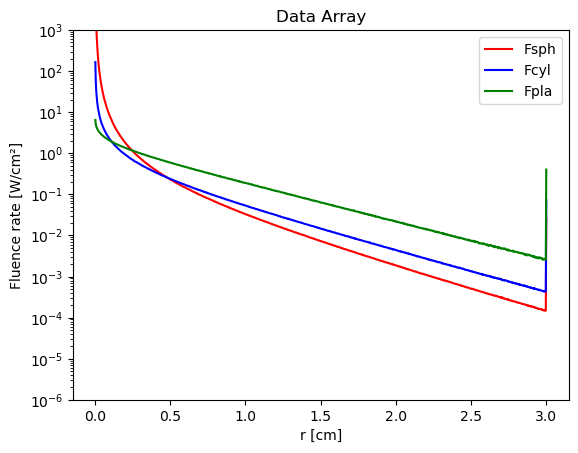

In [24]:
import matplotlib.pyplot as plt

plt.plot(r, Fsph, '-', label='Fsph', color='red')
plt.plot(r, Fcyl, '-', label='Fcyl', color='blue')
plt.plot(r, Fpla, '-', label='Fpla', color='green')
plt.yscale('log')
plt.ylim(1e-6, 1e3)
plt.xlabel('r [cm]')
plt.ylabel('Fluence rate [W/cm²]')
plt.legend()
plt.title('Data Array')
plt.show()